# Реализация Fast R-CNN
Реализовать метод Fast R-CNN. Он будет во многом  похож на R-CNN. Однако, если в случае R-CNN пропозалы и нейросетевой классификатор были двумя независимыми вещами, то в случае Fast R-CNN пропозалы будут использоваться внутри сети, которая делает предсказание.

### Загрузка необходимых библиотек
Здесь мы загружаем различне библиотеки, включая TensoFlow.


In [2]:
import random

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.6.0


## Архитектура Fast R-CNN
Перейдем сразу к архитектуре Fast R-CNN. Все остальыне части пайплайна не отличаются от R-CNN. Внутри Fast R-CNN по-прежнему будет находиться свёрточная нейросеть, которую необходимо обучить на задачу классификации, так же как в R-CNN. 

Однако инференс (детектирование) в Fast R-CNN работает иначе. Вместо того, чтобы запускать классификатор отдельно для каждого пропозала на картинке, мы сначала запускаем первую часть сети, которая извлекает признаки для всей картинки (один раз). А затем отображаем пропозалы в это признаковое пространство, вырезаем соответствующие кусочки, делаем ROI Pooling и прогоняем результат через вторую (классификационную) часть нейросети.

Получается, что у нас есть два режима работа модели: в режиме обучения наша модель работает (обучается) как простой классификатор, а в режиме детектирования модель работает описанным выше хитрым способом. В обоих режимах нам нужно использовать прямое распространение (в обучении это часть всего процесса), которое реализуется функцией `call()`. Таким образом нам придётся как-то организовать два типа поведения в рамках одной модели. Для этого давайте просто в функции `call()`, где и происходит прямое распространение, сделаем условное ветвление: если на вход пришли пропозалы, значит работаем в режиме инференса (предсказание), а если пропозалов нет, значит работаем в режиме обучения (как обычный классификатор). По сути, у нас получится динамический граф -- вызов тех или иных слоёв зависит от входных данных.

В режиме предсказания сначала применим свёрточные и пулинг слои. Затем получим координаты пропозалов в признаковом пространстве. Так как размерность признакового пространства уменьшилась по сравнению с входной картинкой из-за пулинга, то и пропозалы должны пропорционально уменьшиться. А так как у нас координаты пропозалов обычно задаются в относительнеых величинах, значит мы просто будем использовать размеры карт признаков (`feat.shape`) для перехода к абсолютным координатам. После этого вырезаем соответствующи кусочки из карт признаков (берём все каналы) и после приведения к нужному размеру (`roi_pool_size`) подаём этот тензор в полносвязные слои.

Однако, сделаем некоторое упрощение: вместо ROI Pooling, будем использовать похожую по эффекту операцию: простую билинейную интерполяцию -- то есть просто приводить тензоры к нужному фиксированному размеру с помощью resize.

Результаты всех предсказаний (если предсказанный клас не "фон") запишем в выходной список -- аналогично тому, как это было в R-CNN методе.

In [23]:
NUM_CLASSES = 11

class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        
    def call(self, inp, proposals=None):
        
        if proposals is None: # Режим обучения
          
            out = self.conv1(inp)
            out = self.max_pool(out)
            out = self.conv2(out)
            out = self.max_pool(out)
            out = tf.keras.layers.Flatten()(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
          
        else: # Режим предсказания
          
            assert inp.shape[0] == 1 # Только batch size = 1
            predictions = []
            roi_pool_size = (7, 7)
            
            # Извлечение признаков из всей картинки
            out = self.conv1(inp)
            out = self.max_pool(out)
            out = self.conv2(out)
            feat = self.max_pool(out)
            
            # Для каждого пропозала
            for proposal in proposals:
                
                # Отображение координат пространства изображения 
                # в координаты пространства признаков
                ry, rx, rh, rw = proposal        
                box_y = int(round(ry * int(feat.shape[1])))
                box_x = int(round(rx * int(feat.shape[2])))
                box_w = int(round(rw * int(feat.shape[2])))
                box_h = int(round(rh * int(feat.shape[1])))
                
                # Вырезаем признаки, относящиеся к пропозалу
                feat_sub = feat[:, box_y:box_y+box_h, box_x:box_x+box_w, :]
                
                # Аналог ROI Pooling
                feat_pooled = tf.image.resize(
                    feat_sub, 
                    (roi_pool_size[0], roi_pool_size[1]), 
                    tf.image.ResizeMethod.BILINEAR)
                
                # Финальная классификация
                out = tf.keras.layers.Flatten()(feat_pooled)
                out = self.fc1(out)
                out = self.fc2(out)
                
                # Фильтрация класса "фон"
                assert out.shape[0] == 1 # Только batch size = 1
                pred = out[0]
                pred_cls = np.argmax(pred)
                if pred_cls != 10:
                    predictions.append([pred_cls] + proposal)               
        
            return predictions
    
model = Model()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

### Обучение Fast R-CNN
Все остальные части пайплнайна обучения такие же, как и для R-CNN

**[ЗАДАНИЕ ]**: Подготовить необходимые данные: `train_x_cls`, `train_y_cls`, `test_x_det`, `test_y_det`, `test_proposals` точно так же, как это было в уроке про R-CNN. Обучите модель `model` на классификационном датасете, по аналогии с тем, как мы это делали для R-CNN. В режиме обучения в функцию `call()` не будут передаваться пропозалы, поэтому модель будет вести себя как обычный классификатор.

### Запуск детектирования объектов с помощью Fast R-CNN


In [4]:
import random
import numpy as np
import skimage.filters
from skimage.transform import resize

%matplotlib inline
import matplotlib.pyplot as plt

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


In [25]:
hist = model.fit(train_x, train_y, batch_size=128, 
                 epochs=10)

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0233 - accuracy: 0.9929
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0157 - accuracy: 0.9953
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0121 - accuracy: 0.9963
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0101 - accuracy: 0.9969
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0084 - accuracy: 0.9973
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0077 - accuracy: 0.9976
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0079 - accuracy: 0.9973
Epoch 8/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0081 - accuracy: 0.9971
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0058 - accuracy: 0.9980
Epoch 10/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0054 - accura

313/313 [==============================] - 2s 5ms/step - loss: 0.0281 - accuracy: 0.9919


[0.028084997087717056, 0.9919000267982483]

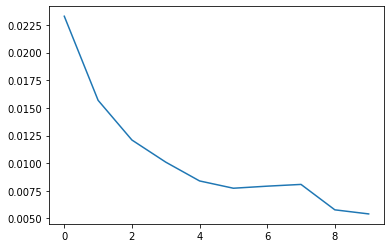

In [27]:
plt.plot(hist.history['loss'])

model.evaluate(test_x, test_y)

In [5]:
bg_source = np.random.rand(1000, 1000, 1).astype(np.float32)
bg_source = skimage.filters.gaussian(bg_source, 4)
bg_source = (bg_source - np.min(bg_source))/(np.max(bg_source) - np.min(bg_source))
bg_source = np.clip(bg_source, 0, 1)

In [6]:
def gen_od_ds(x, y, bg_source, new_size, num_samples, max_num_objects):
    x_new = np.zeros((num_samples, new_size[0], new_size[1], 1), dtype=np.float32)
    y_new = []
    
    rh = float(x.shape[1]) / new_size[0]
    rw = float(x.shape[2]) / new_size[1]
    
    for i in range(num_samples):
        oh = random.randint(0, bg_source.shape[0] - new_size[0])
        ow = random.randint(0, bg_source.shape[1] - new_size[1])
        x_new[i] = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]
        num_of_objects = random.randint(1, max_num_objects)
        y_new.append([])
        for _ in range(num_of_objects):
            sample_idx = random.randint(0, x.shape[0]-1)
            xs = x[sample_idx]
            ys = y[sample_idx]
            ofs = (random.randint(0, x_new[i].shape[0]-xs.shape[0]),
                   random.randint(0, x_new[i].shape[1]-xs.shape[1]))
            x_new[i][ofs[0]:ofs[0]+xs.shape[0], ofs[1]:ofs[1]+xs.shape[1], :] += xs
            ry = float(ofs[0]) / new_size[0]
            rx = float(ofs[1]) / new_size[1]
            y_new[-1].append([ys, ry, rx, rh, rw])
            
        x_new[i] = np.clip(x_new[i], 0.0, 1.0)
        
    return x_new, y_new

In [7]:
new_size = (128, 128)
train_num_samples = 60000
test_num_samples = 10000
max_num_objects = 3 # максимальное кол-во цифр на одном изображении

train_x_det, train_y_det = gen_od_ds(train_x, train_y, bg_source, new_size, train_num_samples, max_num_objects)
test_x_det, test_y_det = gen_od_ds(test_x, test_y, bg_source, new_size, test_num_samples, max_num_objects)

print(train_x.shape)
print(train_y_det[0])
print(test_x.shape)
print(test_y.shape)

(60000, 28, 28, 1)
[[1, 0.015625, 0.546875, 0.21875, 0.21875], [5, 0.6953125, 0.7734375, 0.21875, 0.21875], [2, 0.46875, 0.03125, 0.21875, 0.21875]]
(10000, 28, 28, 1)
(10000,)


In [8]:
def show_prediction(img, preds):
    import matplotlib.patches as patches
    
    fig,ax = plt.subplots(1)
    ax.imshow(img[...,0], 'gray', vmin=0, vmax=1,)
    
    for pred in preds:

        pred_cls = pred[0]
        ry, rx, rh, rw = pred[1:]
        
        box_y = int(ry * img.shape[0])
        box_x = int(rx * img.shape[1])
        box_w = int(rw * img.shape[1])
        box_h = int(rh * img.shape[0])

        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        rect = patches.Rectangle((box_x, box_y), 10, -10, linewidth=1, edgecolor='r', facecolor='r')
        ax.add_patch(rect)
        ax.text(box_x+4, box_y-2, pred_cls)

In [10]:
def gen_proposals(x_det, y_det):
    all_proposals = []
    for boxes in y_det:
        proposals = []
        for box in boxes:
            proposals.append(box[1:])
        all_proposals.append(proposals)
    return all_proposals

In [56]:
test_proposals = gen_proposals(test_x_det, test_y_det)

In [57]:
def model_prediction(img, proposals, inp_size):
    predictions = []
    for proposal in proposals:
        ry, rx, rh, rw = proposal        
        box_y = int(round(ry * img.shape[0]))
        box_x = int(round(rx * img.shape[1]))
        box_w = int(round(rw * img.shape[1]))
        box_h = int(round(rh * img.shape[0]))
        img_sub = img[box_y:box_y+box_h, box_x:box_x+box_w, :]     
        img_inp = resize(img_sub, (inp_size[0], inp_size[1]), 
            order=3, mode='reflect', anti_aliasing=True)
        pred = model.predict(img_inp[None, ...])[0]
        pred_cls = np.argmax(pred)
        if pred_cls != 10:
            predictions.append([pred_cls] + proposal)
    return predictions

In [63]:
idx = random.randint(0, 1000)
img = test_x_det[idx]
labels_true = test_y_det[idx]
proposals_img = test_proposals[idx]

preds = model_prediction(img[None, ...][0], proposals_img, (28, 28))

### Визуализация Ground-Truth

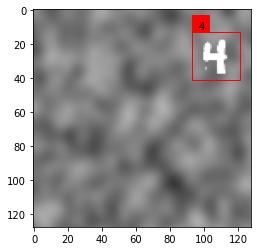

In [64]:
show_prediction(img, labels_true)

### Визуализация пропозалов

In [65]:
def show_proposals(img, proposals):
    import matplotlib.patches as patches
    
    fig,ax = plt.subplots(1)
    ax.imshow(img[...,0], 'gray', vmin=0, vmax=1,)
    
    for proposal in proposals:

        ry, rx, rh, rw = proposal
        
        box_y = int(round(ry * img.shape[0]))
        box_x = int(round(rx * img.shape[1]))
        box_w = int(round(rw * img.shape[1]))
        box_h = int(round(rh * img.shape[0]))

        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

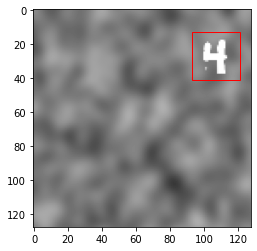

In [66]:
show_proposals(img, proposals_img)

### Визуализация детекций Fast R-CNN

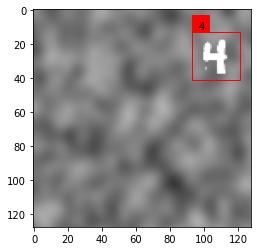

In [67]:
show_prediction(img, preds)